pip install --upgrade pip

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid OOM errors by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [4]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
img = cv2.imread(os.path.join('data', '1', 'WIN_20230321_11_51_45_Pro.jpg'))
print(img.shape)
print(img)

(720, 1280, 3)
[[[124 145 146]
  [126 147 148]
  [129 151 149]
  ...
  [ 67  71  95]
  [ 63  70  90]
  [ 58  65  85]]

 [[124 145 146]
  [127 149 147]
  [129 151 149]
  ...
  [ 66  70  94]
  [ 63  70  90]
  [ 59  66  86]]

 [[124 146 144]
  [127 149 147]
  [130 152 150]
  ...
  [ 65  69  93]
  [ 64  71  91]
  [ 61  68  88]]

 ...

 [[153 164 156]
  [153 164 156]
  [153 164 156]
  ...
  [184 192 182]
  [183 193 181]
  [184 194 182]]

 [[152 165 157]
  [152 165 157]
  [153 164 156]
  ...
  [182 191 181]
  [181 190 180]
  [182 191 181]]

 [[152 165 157]
  [151 164 156]
  [153 164 156]
  ...
  [179 188 178]
  [178 187 177]
  [178 187 177]]]


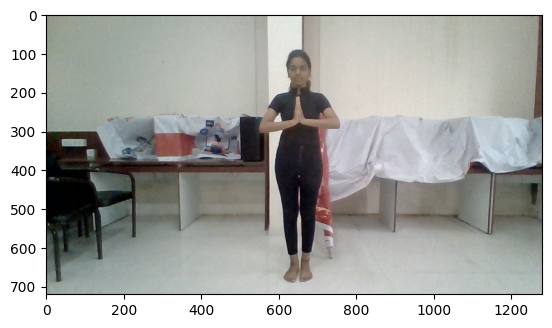

In [6]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        image = cv2.imread(image_path)

        mask = np.zeros(image.shape[:2], np.uint8)

        rectangle = (256, 256, 100, 100)

        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        cv2.grabCut(image, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        mask_binary = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

        segmented_image = image * np.expand_dims(mask_binary, axis=-1)
        
        image = segmented_image

In [14]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 480 files belonging to 6 classes.


In [15]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

In [18]:
batch[0]

array([[[[134.     , 130.     , 118.     ],
         [130.09375, 132.09375, 118.09375],
         [133.     , 136.     , 127.     ],
         ...,
         [ 91.09375,  71.09375,  38.09375],
         [138.5625 , 125.375  ,  93.46875],
         [161.1875 , 160.1875 , 132.1875 ]],

        [[134.71875, 132.71875, 119.71875],
         [129.     , 132.4375 , 117.71875],
         [133.     , 136.     , 125.     ],
         ...,
         [ 95.4375 ,  72.4375 ,  41.4375 ],
         [117.40625, 104.40625,  72.40625],
         [161.28125, 161.28125, 134.71875]],

        [[132.9375 , 132.53125, 119.     ],
         [129.     , 133.     , 118.     ],
         [131.     , 137.     , 125.     ],
         ...,
         [ 96.46875,  71.46875,  41.46875],
         [101.8125 ,  87.8125 ,  58.8125 ],
         [155.46875, 156.53125, 132.53125]],

        ...,

        [[166.53125, 179.53125, 170.53125],
         [171.46875, 184.46875, 175.46875],
         [172.     , 185.     , 176.     ],
         ...,


In [19]:
batch[1]

array([3, 0, 2, 3, 4, 3, 2, 3, 0, 2, 0, 3, 5, 3, 4, 4, 0, 3, 2, 2, 1, 0,
       4, 3, 2, 4, 0, 1, 5, 3, 0, 4])

##
0: Mountain
1: Tree
2: Lotus
3: Lunge
4: Plank
5: DownDog

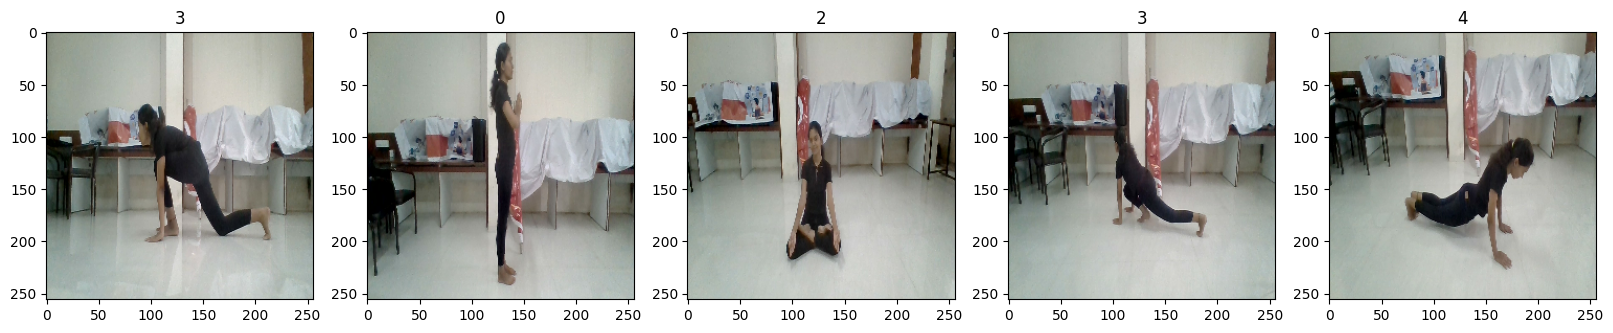

In [20]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [21]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [22]:
batch = data.as_numpy_iterator().next()

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [24]:
print(len(data))
print(train_size)
print(val_size)
print(test_size)

15
10
3
2


In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [26]:
from tensorflow.keras import datasets, layers, models

In [27]:
model = models.Sequential()

In [28]:
model.add(layers.Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3,3), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, (3,3), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [31]:
hist = model.fit(train, epochs=50, validation_data=val)

Epoch 1/50
10/10 [==============================] - 24s 2s/step - loss: 2.6081 - accuracy: 0.3250 - val_loss: 1.1434 - val_accuracy: 0.8958
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.5663 - accuracy: 0.8219 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 22s 2s/step - loss: 0.0530 - accuracy: 0.9875 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 0.0255 - accuracy: 0.9844 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 0.0166 - accuracy: 0.9969 - val_loss: 9.1195e-04 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 22s 2s/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 7.0963e-06 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 3.3155e-07 - val_accuracy: 1.0000
Epoch 8/

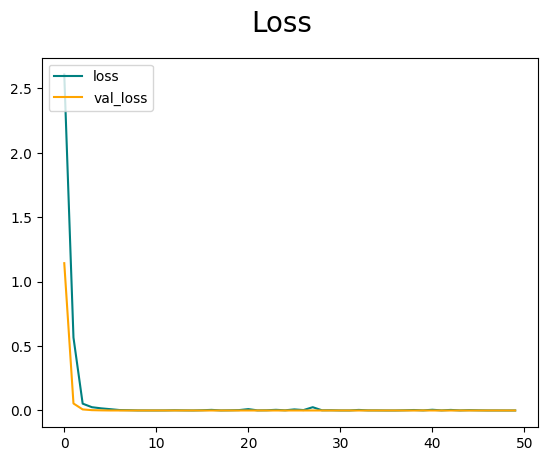

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

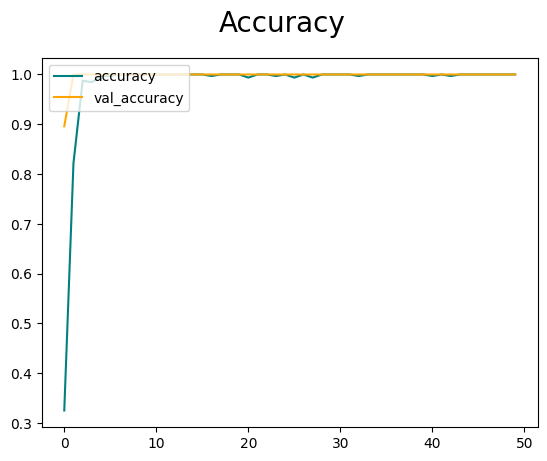

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [34]:
model.evaluate(test)

2/2 [==============================] - 2s 389ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

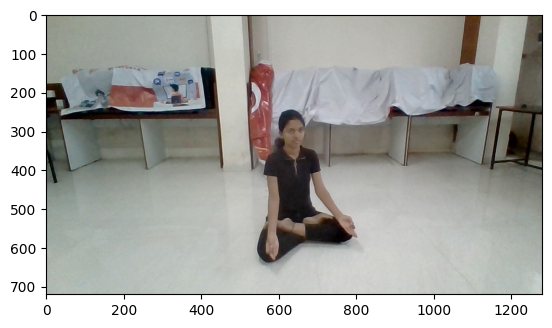

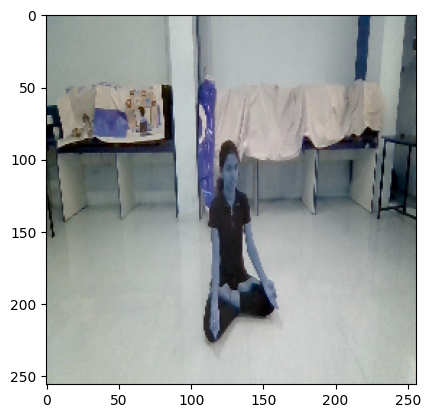

In [60]:
img = cv2.imread('img6.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
ypred = model.predict(np.expand_dims(resize/255, 0))
ypred

1/1 [==============================] - 0s 37ms/step


array([[8.7871421e-24, 2.5435207e-35, 1.0000000e+00, 2.8938477e-24,
        6.7416219e-26, 5.6235523e-29]], dtype=float32)

In [62]:
yclass = [np.argmax(element) for element in ypred]

In [63]:
if ypred[0][yclass] < 0.8:
    print('Try Again')
else:
    print(yclass)

[2]


In [64]:
from tensorflow.keras.models import load_model

In [65]:
model.save(os.path.join('models','trainedmodel1.h5'))